In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pygsp as gsp
import skimage as sk
import scipy.sparse as sparse

In [13]:
def imshow(Image):
    # plt.figure(figsize=(8,10))
    plt.axis('off')
    plt.imshow(Image,cmap='gray')
    
 
def showhimgs(ims,size=(18,14),mode='gray',titles=None,axes=False):
  # display grayscale images passed in list img horizontally 
  nimgs=len(ims)
  fig,axs=plt.subplots(1,nimgs,figsize=size)
  for i in range(nimgs):
    if(axes!=True): axs[i].axis('off')
    axs[i].imshow(ims[i],cmap=mode)
    if(titles):
      axs[i].set_title(titles[i])
  plt.show()

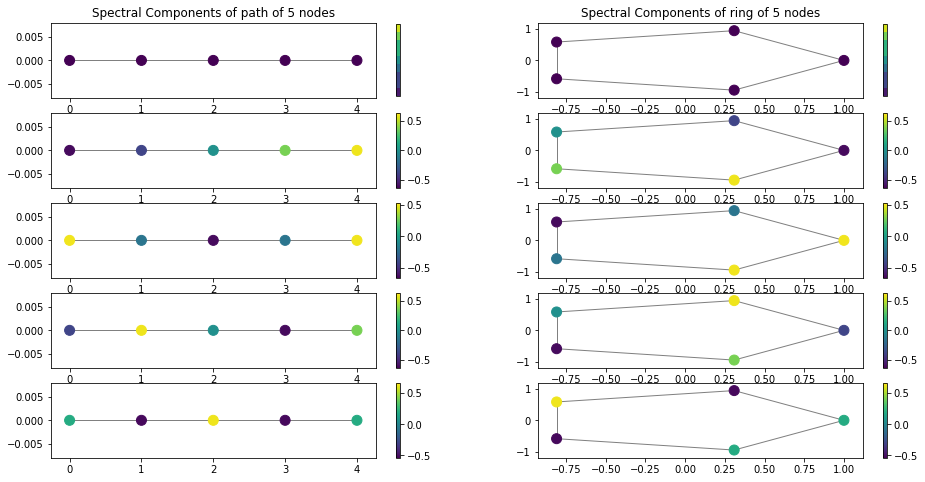

In [14]:
# P=P# change graph
P=gsp.graphs.Path(5)
R=gsp.graphs.Ring(5)
N=5
s=np.zeros(N)
size=(16,8)
fig,axs=plt.subplots(5,2,figsize=size)
P.compute_fourier_basis()
R.compute_fourier_basis()

for n in range(N):
  s[n]=1
  shat=P.igft(s)
  P.plot_signal(shat,ax=axs[n,0])
  R.plot_signal(shat,ax=axs[n,1])
  #if n>0: axs[n].set_title('')
  if(n==0):
    axs[0,0].set_title('Spectral Components of '+P.gtype + ' of ' + str(P.N) + ' nodes')
    axs[0,1].set_title('Spectral Components of '+R.gtype + ' of ' + str(R.N) + ' nodes')
  else:
    axs[n,0].set_title('')
    axs[n,1].set_title('')
  s=np.zeros(N)

plt.show()

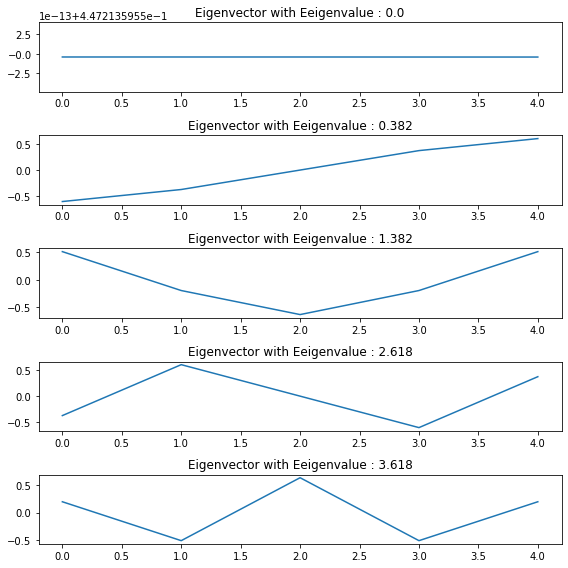

In [15]:
P.compute_fourier_basis()
fig,axs=plt.subplots(5,1,figsize=(8,8))
titles=['Eigenvector with Eeigenvalue : '+str(np.round(i,3)) for i in P.e]

for i in range(5):
  axs[i].set_title(titles[i])
  axs[i].plot(P.U[:,i])

plt.tight_layout()
plt.show()

'\nSmoothest signal representation in vertex domain is therefore [1,1,1,1,1].\nIn the Transform domain, this signal is [1,0,0,0,0]\n'

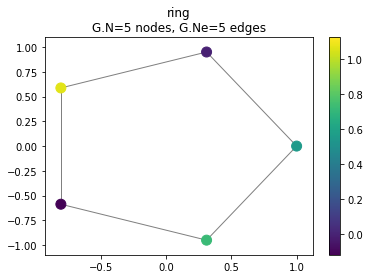

In [16]:
shat=np.zeros(5) 
shat[[0,3]]=1
s=R.igft(shat)
R.plot_signal(s) # smoothest signal: every vertex has signal value equals to 1. 
'''
Smoothest signal representation in vertex domain is therefore [1,1,1,1,1].
In the Transform domain, this signal is [1,0,0,0,0]
'''

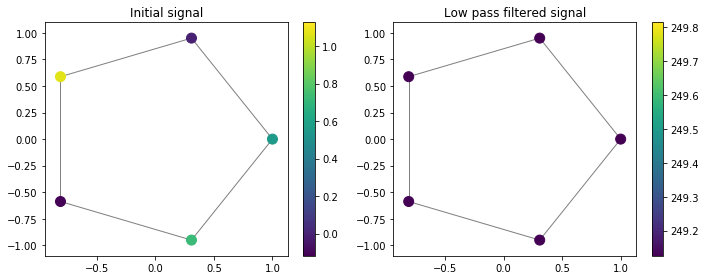

In [17]:
'initial signal'
shat=np.zeros(5) 
shat[[0,3]]=1
s=R.igft(shat)
'filtering'
h = lambda x:1/(1*x)
H = gsp.filters.Filter(R,h)
sprime = H.filter(s)

fig,axs = plt.subplots(1,2,figsize=(10,4))
R.plot_signal(s,ax=axs[0])
axs[0].set_title('Initial signal')
R.plot_signal(sprime,ax=axs[1])
axs[1].set_title('Low pass filtered signal')
plt.tight_layout()
plt.show()

In [18]:
'''
work in progress faster implementation of the function that returns the adjacency matrix of the image graph 
'''
def Img2AdjM(I,Tetha=.1,k=0):
    
    I=I/I.max() 
    
    N=I.shape[0]
    
    # TWG function
    def dist(pixeldiff):
        logic_mask = pixeldiff < k
        dists=np.exp(-np.square(pixeldiff)/(2*Tetha**2)) * logic_mask
        return dists
    
    # get differences:
    hdif=I[:,:N-1]-I[:,1:] # horizontal differences
    vdif=I[:N-1,:]-I[1:,:] # vertical differences
    rddif=I[:N-1,:N-1]-I[1:,1:] # differences parallel to right diagonal
    lddif=I[:N-1,1:]-I[1:,:N-1] # differences parallel to left diagonal
    
    # get TWG from differences
    hdif,vdif,rddif,lddif= dist(np.ravel(hdif)),dist(np.ravel(vdif)),dist(np.ravel(rddif)),dist(np.ravel(lddif))
    
    # insert null spaces
    hidx=np.array([n*N for n in range(1,N)])
    hdif=np.insert(hdif,hidx,0)
#     print(len(hdif)==(N**2-1))
    
    rdidx=np.array([n*N for n in range(1,N-1)])
    rddif=np.insert(rddif,rdidx,0)
#     print(len(rddif)==(N**2-N-1))
    
    ldidx=np.array([n*N for n in range(N-1)])
    lddif=np.insert(lddif,ldidx,0)
    lddif=np.append(lddif,0) # last one needs to be appended 
#     print(len(lddif)==(N**2-N+1))

    # return sparse matrix
    return sparse.diags([hdif,hdif,vdif,vdif,rddif,rddif,lddif,lddif],[1,-1,N,-N,N+1,-(N+1),N-1,-(N-1)])

# AdjM = Img2AdjM(Ismall)

In [19]:
path=r"C:\Users\vokyj\Documents\CDT\YEAR_1\Strathclyde\Concepts Signal Image Processing\Tutorials\ICMP.jpeg"
I=sk.io.imread(path)
Ismall=I # smaller version of image (if needed)
# set every value in the image in the range (01)
Ismall=Ismall/Ismall.max() # normalize image values, important for weight calculation
# plt.imshow(Ismall,cmap='gray')
Ismall.shape
Ismall_n=sk.util.random_noise(Ismall,var=.01)
# showhimgs([Ismall,Ismall_n])
# Classical filter
I_Gaussian = sk.filters.gaussian(Ismall_n)
# Graph filter
AdjM=Img2AdjM(Ismall_n)
G=gsp.graphs.Graph(AdjM)
G.estimate_lmax()
s0=Ismall_n.ravel() # intial signal (image pixels intensity values)
H=gsp.filters.Filter(G,lambda x : 1/(x+1))
s=H.filter(s0)
I_graph = s.reshape((512,512))

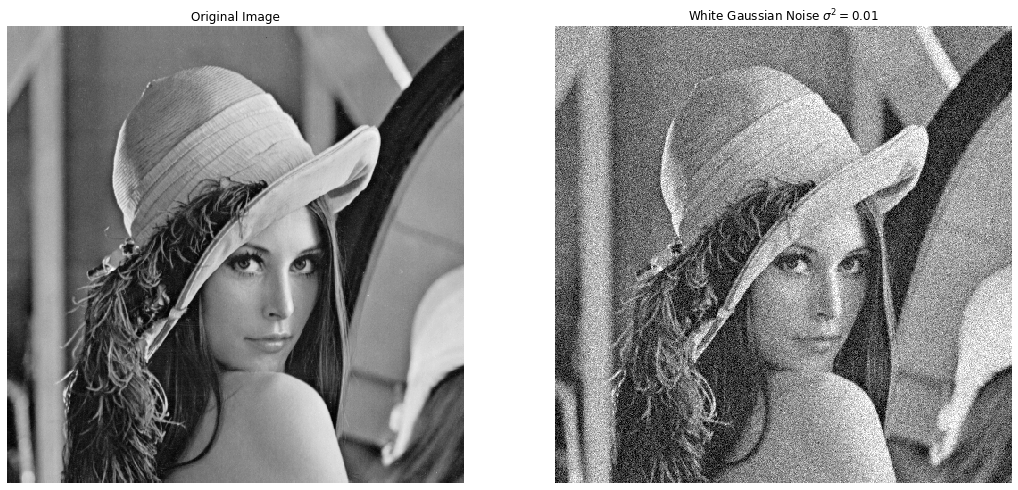

In [20]:
showhimgs([Ismall,Ismall_n],titles=['Original Image','White Gaussian Noise $\sigma^2 = 0.01$'])

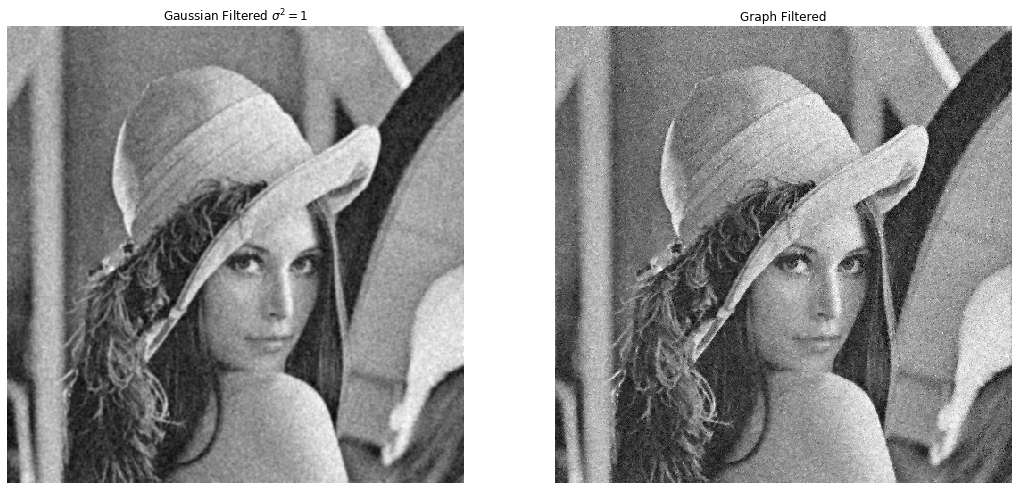

In [21]:
showhimgs([I_Gaussian,I_graph],titles=['Gaussian Filtered $\sigma^2 = 1$','Graph Filtered'])

In [22]:
# Classical filter
I=sk.data.camera()
Ismall2=I # smaller version of image (if needed)
# set every value in the image in the range (01)
Ismall2=Ismall2/Ismall2.max() # normalize image values, important for weight calculation
# plt.imshow(Ismall,cmap='gray')
Ismall2.shape
Ismall2_n=sk.util.random_noise(Ismall2,var=.01)
# showhimgs([Ismall,Ismall_n])
I_Gaussian2 = sk.filters.gaussian(Ismall2_n)
# Graph filter
AdjM2=Img2AdjM(Ismall2_n)
G=gsp.graphs.Graph(AdjM2)
G.estimate_lmax()
s0=Ismall2_n.ravel() # intial signal (image pixels intensity values)
H=gsp.filters.Filter(G,lambda x : 1/(x+1))
s=H.filter(s0)
I_graph2 = s.reshape((512,512))

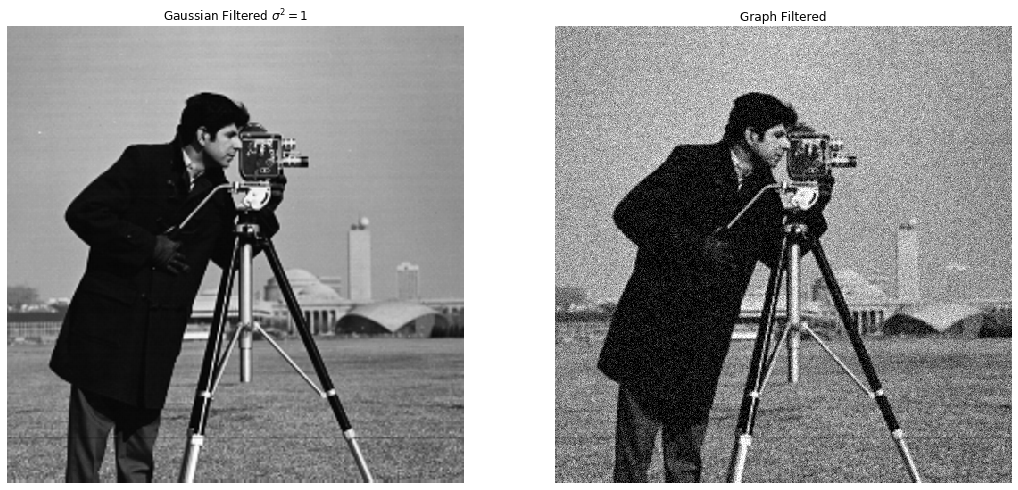

In [25]:
showhimgs([Ismall2,Ismall2_n],titles=['Gaussian Filtered $\sigma^2 = 1$','Graph Filtered'])

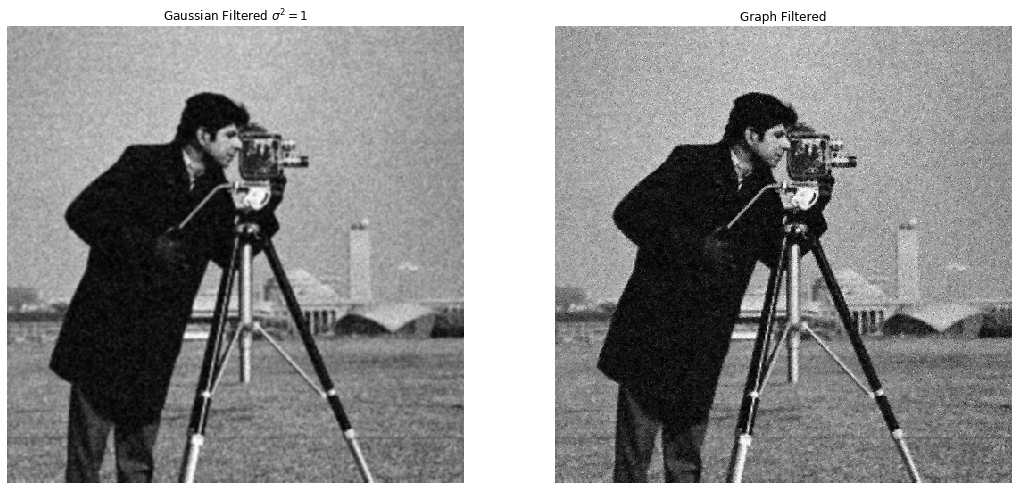

In [23]:
showhimgs([I_Gaussian2,I_graph2],titles=['Gaussian Filtered $\sigma^2 = 1$','Graph Filtered'])

[]

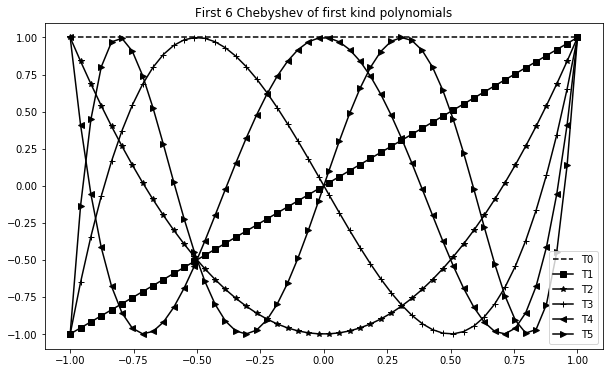

In [24]:
# CHEBYSHEV POLYNOMIALS
T0 = lambda x : x**0
T1 = lambda x : x
T2 = lambda x : 2*x**2-1
T3 = lambda x : 4*x**3 - 3*x
T4 = lambda x : 8*x**4 - 8*x**2 + 1
T5 = lambda x : 16*x**5 - 20*x**3 + 5*x
x = np.linspace(-1,1)
# print(T2(x))
fig,axs = plt.subplots(1,1,figsize = (10,6))
axs.plot(x,T0(x),'k--',label='T0')
axs.plot(x,T1(x),'ks-',label='T1')
axs.plot(x,T2(x),'k*-',label='T2')
axs.plot(x,T3(x),'k+-',label='T3')
axs.plot(x,T4(x),'k<-',label='T4')
axs.plot(x,T5(x),'k>-',label='T5')
axs.legend()
axs.set_title('First 6 Chebyshev of first kind polynomials')
axs.plot()